<a href="https://colab.research.google.com/github/Yomna-Abdelghany/Data-Analysis-task/blob/main/EDA%26StatFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final project
- Business Questions
 - Does the region significantly affect energy consumption?
 - Is there a relationship between the time of day and energy consumption?
 - Assuming that we can shutdown few cells were the consumption is low, what is the threshold that you would recommend and how much KW and EGP it would save accordingly?



### Exploring Data & Importing Libraries

In [ ]:
!pip install pingouin

In [ ]:
! pip install pyod

In [ ]:
# import needed libraries
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import zscore
# statistics
import pingouin as pg
from scipy.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency



In [ ]:
#Read data
folder_path = '/content/drive/MyDrive/Colab Notebooks/Carerha/Data/Final Project'

dfs= []
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)


consumption = pd.concat(dfs, ignore_index=True)
consumption

demand = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Carerha/Data/Final Project/Demand.xlsx')


In [ ]:
demand

,DemandDateTime,Demand
0,2013-01-01 00:00:00,Normal
1,2013-01-01 00:30:00,Normal
2,2013-01-01 01:00:00,Normal
3,2013-01-01 01:30:00,Normal
4,2013-01-01 02:00:00,Normal
...,...,...
17515,2013-12-31 21:30:00,Normal
17516,2013-12-31 22:00:00,Normal
17517,2013-12-31 22:30:00,Normal
17518,2013-12-31 23:00:00,Normal


In [ ]:
consumption

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000002,"00:00:00 13,01,01",0.219,A,A
1,MAC000002,"00:30:00 13,01,01",0.241,A,A
2,MAC000002,"01:00:00 13,01,01",0.191,A,A
3,MAC000002,"01:30:00 13,01,01",0.235,A,A
4,MAC000002,"02:00:00 13,01,01",0.182,A,A
...,...,...,...,...,...
1380247,MAC000069,"20:00:00 13,12,05",0.061,G,C
1380248,MAC000069,"20:30:00 13,12,05",0.090,G,C
1380249,MAC000069,"21:00:00 13,12,05",0.069,G,C
1380250,MAC000069,"21:30:00 13,12,05",0.084,G,C


In [ ]:
print(demand.info())
print(consumption.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DemandDateTime  17520 non-null  datetime64[ns]
 1   Demand          17520 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 273.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380252 entries, 0 to 1380251
Data columns (total 5 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   cell_id                  1380252 non-null  object 
 1   DateTime                 1380252 non-null  object 
 2   KWH/hh (per half hour)   1380252 non-null  float64
 3   site_id                  1380252 non-null  object 
 4   region                   1380252 non-null  object 
dtypes: float64(1), object(4)
memory usage: 52.7+ MB
None


### Cleaning and Transformation

In [ ]:
# removing spaces from column names
df.columns = df.columns.str.strip()

In [ ]:
demand['Demand'].value_counts()

,count
Demand,
Normal,15069
Low,1660
High,785
high,3
normal,2
Normall,1


In [ ]:
demand.isnull().sum()

,0
DemandDateTime,0
Demand,0


In [ ]:
demand['Demand']=demand['Demand'].str.lower()
demand['Demand'] = demand['Demand'].replace({'normall': 'normal'})
demand['Demand'].value_counts()

,count
Demand,
normal,15072
low,1660
high,788


In [ ]:
demand.duplicated().sum()

0

In [ ]:
consumption.isnull().sum()

,0
cell_id,0
DateTime,0
KWH/hh (per half hour),0
site_id,0
region,0


In [ ]:
consumption['DateTime'] = pd.to_datetime(consumption['DateTime'],format='%H:%M:%S %y,%d,%m')

In [ ]:
consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380252 entries, 0 to 1380251
Data columns (total 5 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   cell_id                  1380252 non-null  object        
 1   DateTime                 1380252 non-null  datetime64[ns]
 2   KWH/hh (per half hour)   1380252 non-null  float64       
 3   site_id                  1380252 non-null  object        
 4   region                   1380252 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 52.7+ MB


In [ ]:
consumption.duplicated().sum()

942

In [ ]:
consumption.drop_duplicates(inplace=True)
consumption.duplicated().sum()

0

In [ ]:
consumption['region'].value_counts()

,count
region,
A,541421
B,438096
C,364754
D,35039


In [ ]:
# merging the dfs while making sure it has all the values
new = demand.rename(columns={'DemandDateTime': 'DateTime'})
df = pd.merge(consumption, new, on='DateTime',how='left')
df

,cell_id,DateTime,KWH/hh (per half hour),site_id,region,Demand
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,normal
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,normal
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,normal
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,normal
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,normal
...,...,...,...,...,...,...
1379305,MAC000069,2013-05-12 20:00:00,0.061,G,C,normal
1379306,MAC000069,2013-05-12 20:30:00,0.090,G,C,normal
1379307,MAC000069,2013-05-12 21:00:00,0.069,G,C,normal
1379308,MAC000069,2013-05-12 21:30:00,0.084,G,C,normal


In [ ]:
# renaming columns to readable names
df.rename(columns={'KWH/hh (per half hour) ': 'consumption_hh'},inplace=True)
df.rename(columns={'Demand': 'demand'},inplace=True)
df

,cell_id,DateTime,consumption_hh,site_id,region,demand
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,normal
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,normal
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,normal
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,normal
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,normal
...,...,...,...,...,...,...
1379305,MAC000069,2013-05-12 20:00:00,0.061,G,C,normal
1379306,MAC000069,2013-05-12 20:30:00,0.090,G,C,normal
1379307,MAC000069,2013-05-12 21:00:00,0.069,G,C,normal
1379308,MAC000069,2013-05-12 21:30:00,0.084,G,C,normal


In [ ]:
# mapping the price according to demand
price = {
   'normal': 19.46,
   'high' : 77.21,
   'low' : 6.89
}
df['price']= df['demand'].map(price)
df

,cell_id,DateTime,consumption_hh,site_id,region,demand,price
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,normal,19.46
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,normal,19.46
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,normal,19.46
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,normal,19.46
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,normal,19.46
...,...,...,...,...,...,...,...
1379305,MAC000069,2013-05-12 20:00:00,0.061,G,C,normal,19.46
1379306,MAC000069,2013-05-12 20:30:00,0.090,G,C,normal,19.46
1379307,MAC000069,2013-05-12 21:00:00,0.069,G,C,normal,19.46
1379308,MAC000069,2013-05-12 21:30:00,0.084,G,C,normal,19.46


In [ ]:
df['cost'] = df['consumption_hh'] * (df['price'] / 2)
df

,cell_id,DateTime,consumption_hh,site_id,region,demand,price,cost
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,normal,19.46,2.13087
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,normal,19.46,2.34493
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,normal,19.46,1.85843
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,normal,19.46,2.28655
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,normal,19.46,1.77086
...,...,...,...,...,...,...,...,...
1379305,MAC000069,2013-05-12 20:00:00,0.061,G,C,normal,19.46,0.59353
1379306,MAC000069,2013-05-12 20:30:00,0.090,G,C,normal,19.46,0.87570
1379307,MAC000069,2013-05-12 21:00:00,0.069,G,C,normal,19.46,0.67137
1379308,MAC000069,2013-05-12 21:30:00,0.084,G,C,normal,19.46,0.81732


### Exploratory Analysis EDA & Anomaly Detection

In [ ]:
df['hour'] = pd.to_datetime(df['DateTime']).dt.hour
df['day'] = pd.to_datetime(df['DateTime']).dt.day
df['weekday'] = pd.to_datetime(df['DateTime']).dt.weekday
df['month'] = pd.to_datetime(df['DateTime']).dt.month
df

,cell_id,DateTime,consumption_hh,site_id,region,demand,price,cost,hour,day,weekday,month
0,MAC000002,2013-01-01 00:00:00,0.219,A,A,normal,19.46,2.13087,0,1,1,1
1,MAC000002,2013-01-01 00:30:00,0.241,A,A,normal,19.46,2.34493,0,1,1,1
2,MAC000002,2013-01-01 01:00:00,0.191,A,A,normal,19.46,1.85843,1,1,1,1
3,MAC000002,2013-01-01 01:30:00,0.235,A,A,normal,19.46,2.28655,1,1,1,1
4,MAC000002,2013-01-01 02:00:00,0.182,A,A,normal,19.46,1.77086,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1379305,MAC000069,2013-05-12 20:00:00,0.061,G,C,normal,19.46,0.59353,20,12,6,5
1379306,MAC000069,2013-05-12 20:30:00,0.090,G,C,normal,19.46,0.87570,20,12,6,5
1379307,MAC000069,2013-05-12 21:00:00,0.069,G,C,normal,19.46,0.67137,21,12,6,5
1379308,MAC000069,2013-05-12 21:30:00,0.084,G,C,normal,19.46,0.81732,21,12,6,5


In [ ]:
df.drop('cell_id',axis=1,inplace=True)
df

,DateTime,consumption_hh,site_id,region,demand,price,cost,hour,day,weekday,month
0,2013-01-01 00:00:00,0.219,A,A,normal,19.46,2.13087,0,1,1,1
1,2013-01-01 00:30:00,0.241,A,A,normal,19.46,2.34493,0,1,1,1
2,2013-01-01 01:00:00,0.191,A,A,normal,19.46,1.85843,1,1,1,1
3,2013-01-01 01:30:00,0.235,A,A,normal,19.46,2.28655,1,1,1,1
4,2013-01-01 02:00:00,0.182,A,A,normal,19.46,1.77086,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1379305,2013-05-12 20:00:00,0.061,G,C,normal,19.46,0.59353,20,12,6,5
1379306,2013-05-12 20:30:00,0.090,G,C,normal,19.46,0.87570,20,12,6,5
1379307,2013-05-12 21:00:00,0.069,G,C,normal,19.46,0.67137,21,12,6,5
1379308,2013-05-12 21:30:00,0.084,G,C,normal,19.46,0.81732,21,12,6,5


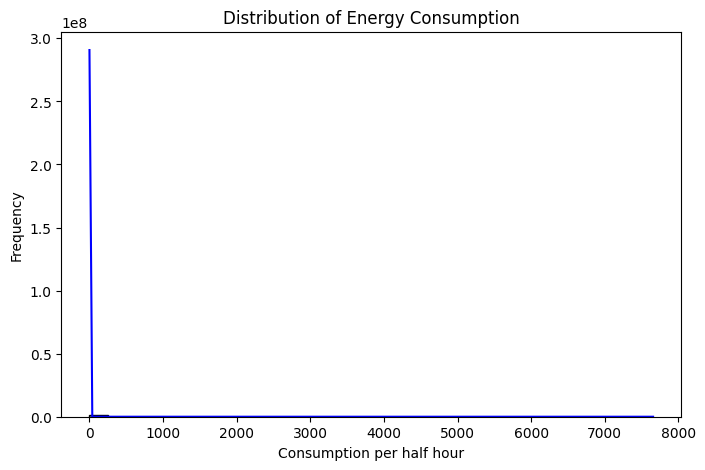

In [ ]:
# Histogram: Energy Consumption Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['consumption_hh'], bins=30, kde=True, color='blue')
plt.title('Distribution of Energy Consumption')
plt.xlabel('Consumption per half hour')
plt.ylabel('Frequency')
plt.show()

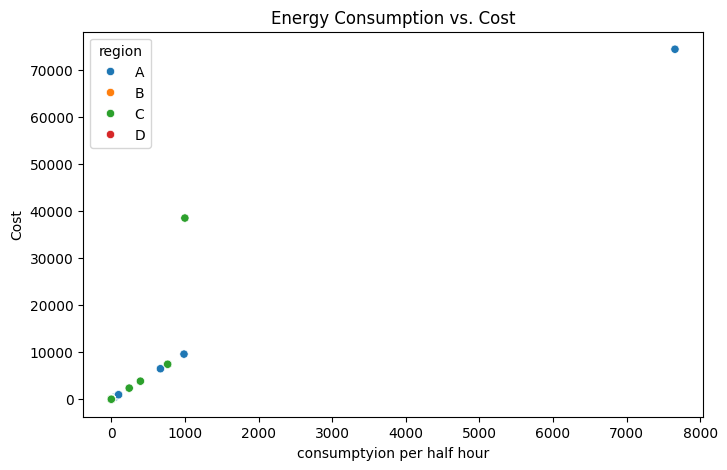

In [ ]:
# Scatter Plot: Energy Consumption vs. Cost
plt.figure(figsize=(8, 5))
sns.scatterplot(x='consumption_hh', y='cost', data=df, hue='region')
plt.title('Energy Consumption vs. Cost')
plt.xlabel('consumptyion per half hour')
plt.ylabel('Cost')
plt.show()

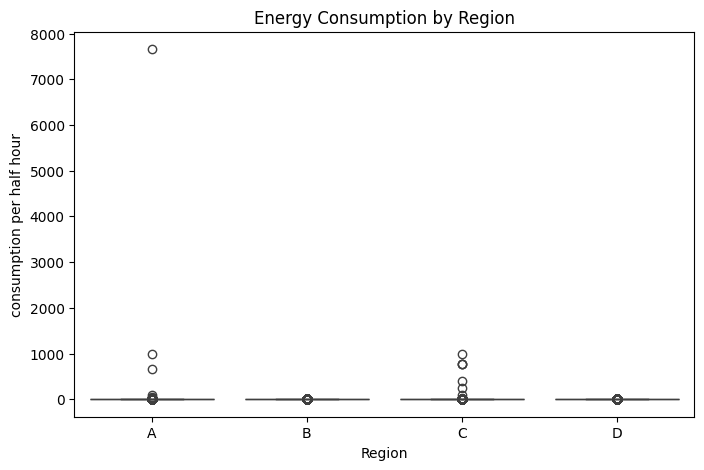

In [ ]:
# Box Plot: Energy Consumption by Region
plt.figure(figsize=(8, 5))
sns.boxplot(x='region', y='consumption_hh', data=df)
plt.title('Energy Consumption by Region')
plt.xlabel('Region')
plt.ylabel('consumption per half hour')
plt.show()


**The visualization for the data shwos that there are outliers preventing us from seeing the data distribution**


---



#### We only need univariate Anomaly Detection here because it is the only variable (consumption_hh) that could affect the data the rest is categorial, date, and time

In [ ]:
# Calculate Z-scores
df['z_score'] = zscore(df['consumption_hh'])

# Flagging outliers
df['is_outlier_z'] = df['z_score'].apply(lambda x: True if abs(x) > 3 else False)

# View outliers
outliers_z = df[df['is_outlier_z']]
outliers_z

,DateTime,consumption_hh,site_id,region,demand,price,cost,hour,day,weekday,month,z_score,is_outlier_z
484646,2013-05-25 05:30:00,765.0,G,C,normal,19.46,7443.450,5,25,5,5,113.000616,True
484823,2013-05-28 22:00:00,98.0,G,C,normal,19.46,953.540,22,28,1,5,14.444676,True
484859,2013-05-29 16:00:00,395.0,G,C,normal,19.46,3843.350,16,29,2,5,58.329405,True
485201,2013-06-05 19:00:00,765.0,G,C,normal,19.46,7443.450,19,5,2,6,113.000616,True
935568,2013-01-18 18:30:00,7657.0,E,A,normal,19.46,74502.610,18,18,4,1,1131.362747,True
936173,2013-01-31 09:00:00,987.0,E,A,normal,19.46,9603.510,9,31,3,1,145.803343,True
936299,2013-02-03 00:00:00,45.0,E,A,normal,19.46,437.850,0,3,6,2,6.613394,True
1123339,2013-10-08 12:00:00,667.0,E,A,normal,19.46,6489.910,12,8,1,10,98.520133,True
1123365,2013-10-09 01:00:00,34.0,E,A,normal,19.46,330.820,1,9,2,10,4.988034,True
1123390,2013-10-09 13:30:00,98.0,E,A,normal,19.46,953.540,13,9,2,10,14.444676,True


In [ ]:
# IQR
def find_anomalies_IQR(df, col_name):
  q1, q3 = np.quantile(df[col_name], [0.25, 0.75])
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr

  df['AD_IQR_' + col_name] = np.where((df[col_name] > upper_bound) | (df[col_name] < lower_bound), 1, 0)

  return df

for col in ['consumption_hh']:
  df = find_anomalies_IQR(df, col)

df

,DateTime,consumption_hh,site_id,region,demand,price,cost,hour,day,weekday,month,z_score,is_outlier_z,AD_IQR_consumption_hh
0,2013-01-01 00:00:00,0.219,A,A,normal,19.46,2.13087,0,1,1,1,-0.003448,False,0
1,2013-01-01 00:30:00,0.241,A,A,normal,19.46,2.34493,0,1,1,1,-0.000197,False,0
2,2013-01-01 01:00:00,0.191,A,A,normal,19.46,1.85843,1,1,1,1,-0.007585,False,0
3,2013-01-01 01:30:00,0.235,A,A,normal,19.46,2.28655,1,1,1,1,-0.001084,False,0
4,2013-01-01 02:00:00,0.182,A,A,normal,19.46,1.77086,2,1,1,1,-0.008915,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379305,2013-05-12 20:00:00,0.061,G,C,normal,19.46,0.59353,20,12,6,5,-0.026794,False,0
1379306,2013-05-12 20:30:00,0.090,G,C,normal,19.46,0.87570,20,12,6,5,-0.022509,False,0
1379307,2013-05-12 21:00:00,0.069,G,C,normal,19.46,0.67137,21,12,6,5,-0.025612,False,0
1379308,2013-05-12 21:30:00,0.084,G,C,normal,19.46,0.81732,21,12,6,5,-0.023396,False,0


In [ ]:
# Filter the rows where is_outlier_z is True and any of the anomaly  has a value of 1
anomalies = df[(df["is_outlier_z"] == True) & (df['AD_IQR_consumption_hh']==1)]

# Display the filtered rows
anomalies

,DateTime,consumption_hh,site_id,region,demand,price,cost,hour,day,weekday,month,z_score,is_outlier_z,AD_IQR_consumption_hh
484646,2013-05-25 05:30:00,765.0,G,C,normal,19.46,7443.450,5,25,5,5,113.000616,True,1
484823,2013-05-28 22:00:00,98.0,G,C,normal,19.46,953.540,22,28,1,5,14.444676,True,1
484859,2013-05-29 16:00:00,395.0,G,C,normal,19.46,3843.350,16,29,2,5,58.329405,True,1
485201,2013-06-05 19:00:00,765.0,G,C,normal,19.46,7443.450,19,5,2,6,113.000616,True,1
935568,2013-01-18 18:30:00,7657.0,E,A,normal,19.46,74502.610,18,18,4,1,1131.362747,True,1
936173,2013-01-31 09:00:00,987.0,E,A,normal,19.46,9603.510,9,31,3,1,145.803343,True,1
936299,2013-02-03 00:00:00,45.0,E,A,normal,19.46,437.850,0,3,6,2,6.613394,True,1
1123339,2013-10-08 12:00:00,667.0,E,A,normal,19.46,6489.910,12,8,1,10,98.520133,True,1
1123365,2013-10-09 01:00:00,34.0,E,A,normal,19.46,330.820,1,9,2,10,4.988034,True,1
1123390,2013-10-09 13:30:00,98.0,E,A,normal,19.46,953.540,13,9,2,10,14.444676,True,1


In [ ]:
df.drop(anomalies.index, inplace=True)
df = df.drop(columns=['z_score',	'is_outlier_z',	'AD_IQR_consumption_hh'])
df

,DateTime,consumption_hh,site_id,region,demand,price,cost,hour,day,weekday,month
0,2013-01-01 00:00:00,0.219,A,A,normal,19.46,2.13087,0,1,1,1
1,2013-01-01 00:30:00,0.241,A,A,normal,19.46,2.34493,0,1,1,1
2,2013-01-01 01:00:00,0.191,A,A,normal,19.46,1.85843,1,1,1,1
3,2013-01-01 01:30:00,0.235,A,A,normal,19.46,2.28655,1,1,1,1
4,2013-01-01 02:00:00,0.182,A,A,normal,19.46,1.77086,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1379305,2013-05-12 20:00:00,0.061,G,C,normal,19.46,0.59353,20,12,6,5
1379306,2013-05-12 20:30:00,0.090,G,C,normal,19.46,0.87570,20,12,6,5
1379307,2013-05-12 21:00:00,0.069,G,C,normal,19.46,0.67137,21,12,6,5
1379308,2013-05-12 21:30:00,0.084,G,C,normal,19.46,0.81732,21,12,6,5


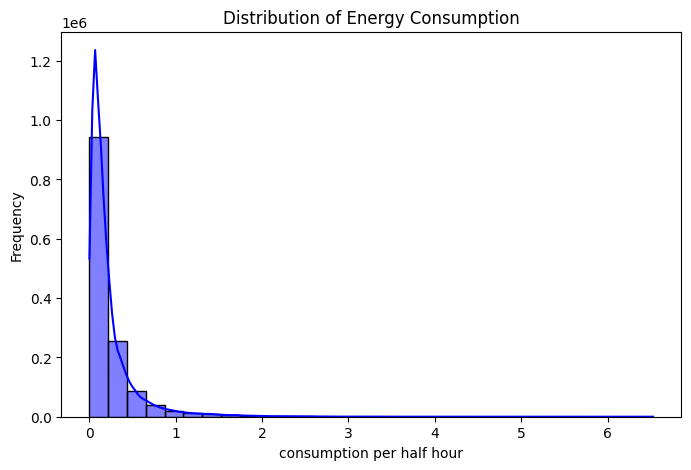

In [ ]:
# Histogram: Energy Consumption Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['consumption_hh'], bins=30, kde=True, color='blue')
plt.title('Distribution of Energy Consumption')
plt.xlabel('consumption per half hour')
plt.ylabel('Frequency')
plt.show()

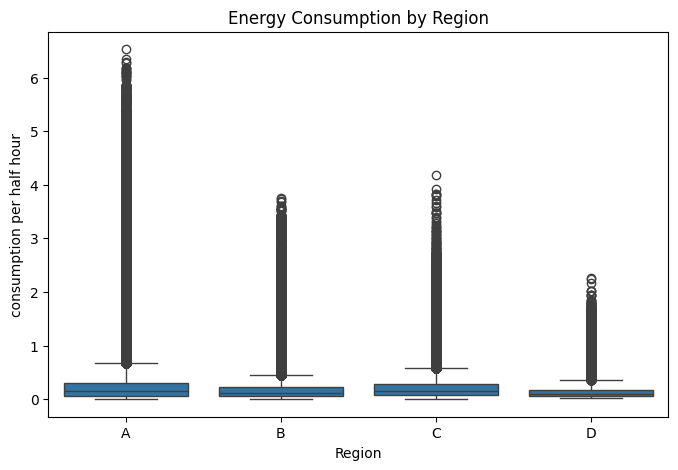

In [ ]:
# Box Plot: Energy Consumption by Region
plt.figure(figsize=(8, 5))
sns.boxplot(x='region', y='consumption_hh', data=df)
plt.title('Energy Consumption by Region')
plt.xlabel('Region')
plt.ylabel('consumption per half hour')
plt.show()


### Feature Enginering

In [ ]:
daily_consumption = df.resample('D', on='DateTime')['consumption_hh'].sum().reset_index()
daily_consumption

,DateTime,consumption_hh
0,2013-01-01,1133.452000
1,2013-01-02,1127.073000
2,2013-01-03,1083.586000
3,2013-01-04,1066.037999
4,2013-01-05,1072.674000
...,...,...
360,2013-12-27,982.899001
361,2013-12-28,948.831999
362,2013-12-29,955.421999
363,2013-12-30,960.640001


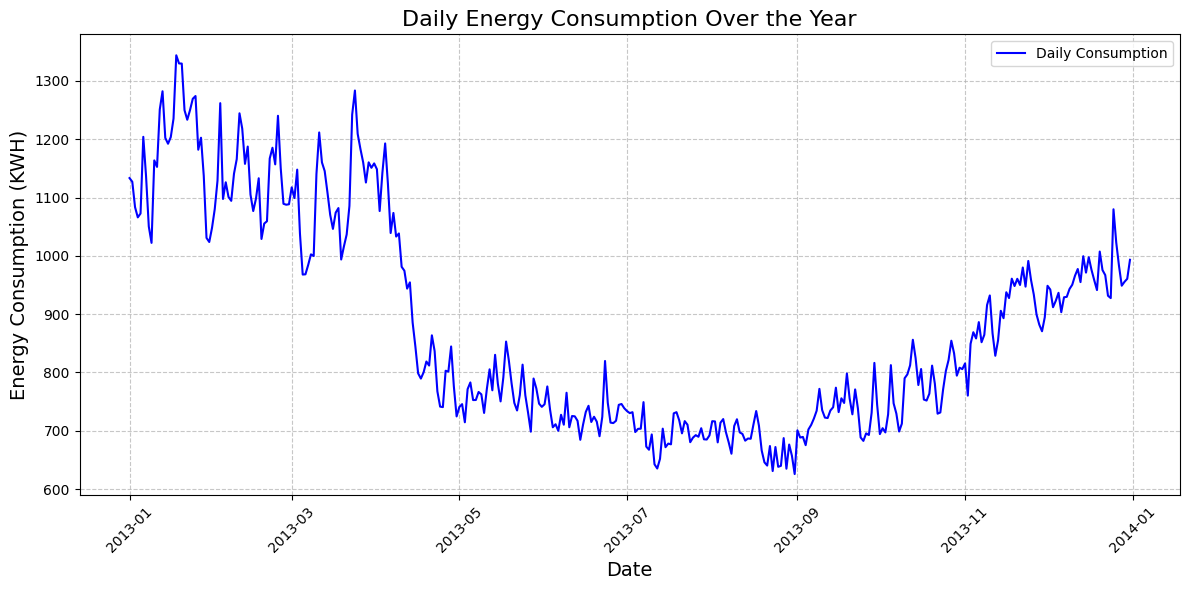

In [ ]:
# visualizing the daily consumption
plt.figure(figsize=(12, 6))
plt.plot(daily_consumption['DateTime'], daily_consumption['consumption_hh'], label='Daily Consumption', color='blue')
plt.title('Daily Energy Consumption Over the Year', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Energy Consumption (KWH)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

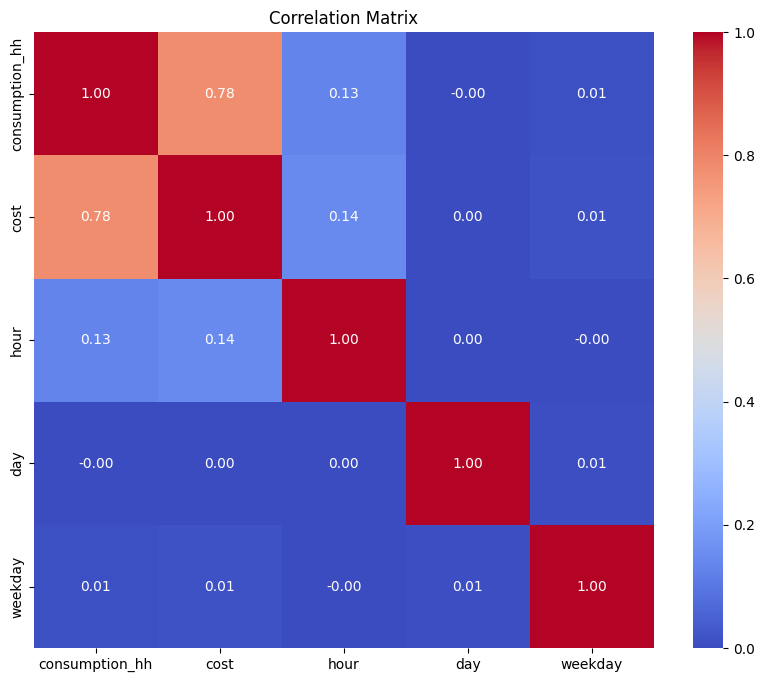

In [ ]:
# Calculate the correlation matrix
corr_df = df[['consumption_hh', 'cost', 'hour', 'day', 'weekday']]
correlation_matrix = corr_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

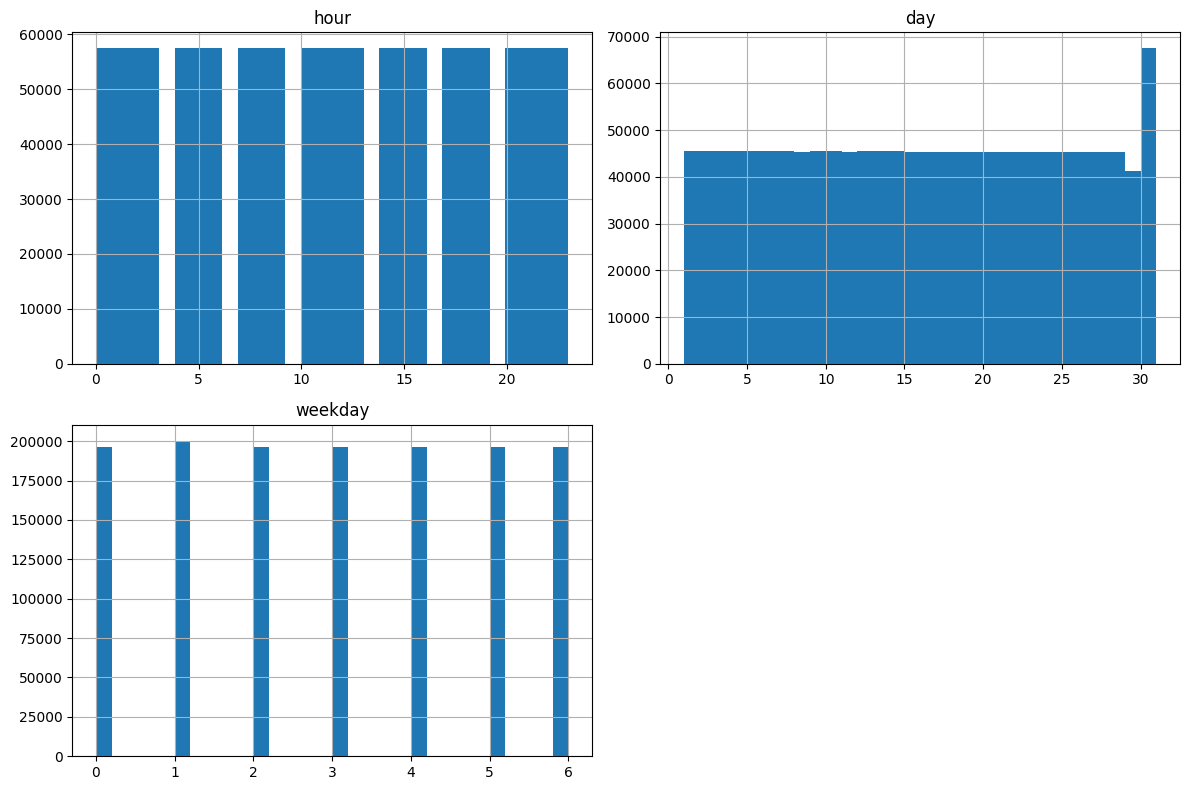

In [ ]:
# Plot histograms for time analysis
df[['hour', 'day', 'weekday']].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()


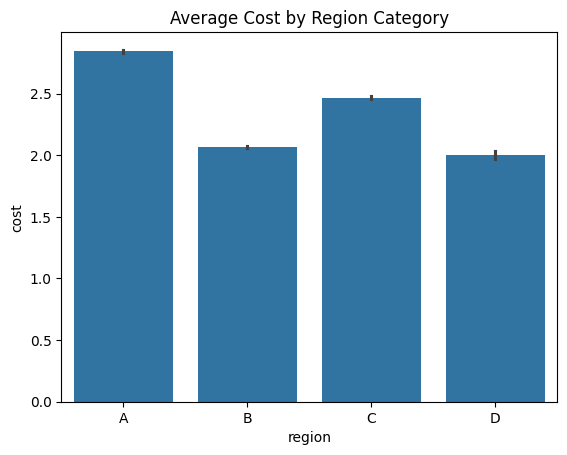

In [ ]:
# Bar plot of average cost by price category
sns.barplot(x='region', y='cost', data=df)
plt.title('Average Cost by Region Category')
plt.show()

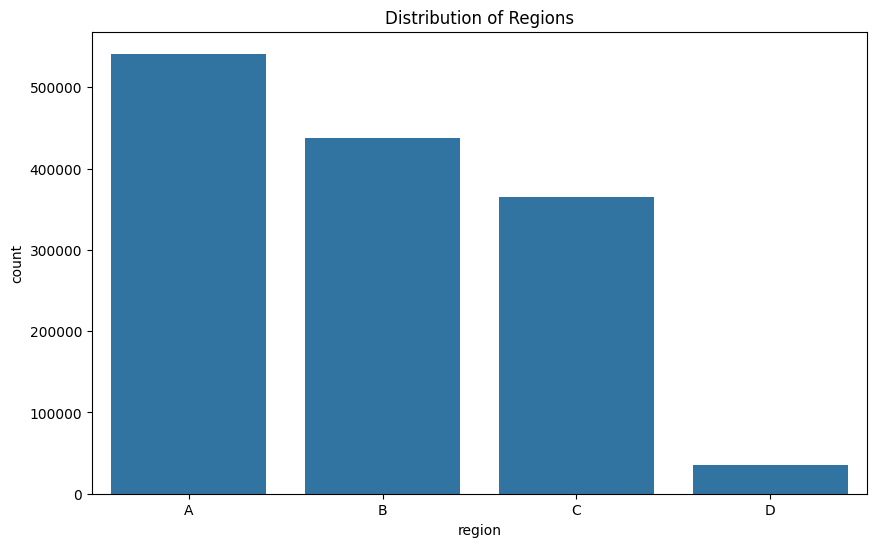

In [ ]:
# Count plot for regions
plt.figure(figsize=(10, 6))
sns.countplot(x='region', data=df)
plt.title('Distribution of Regions')
plt.show()


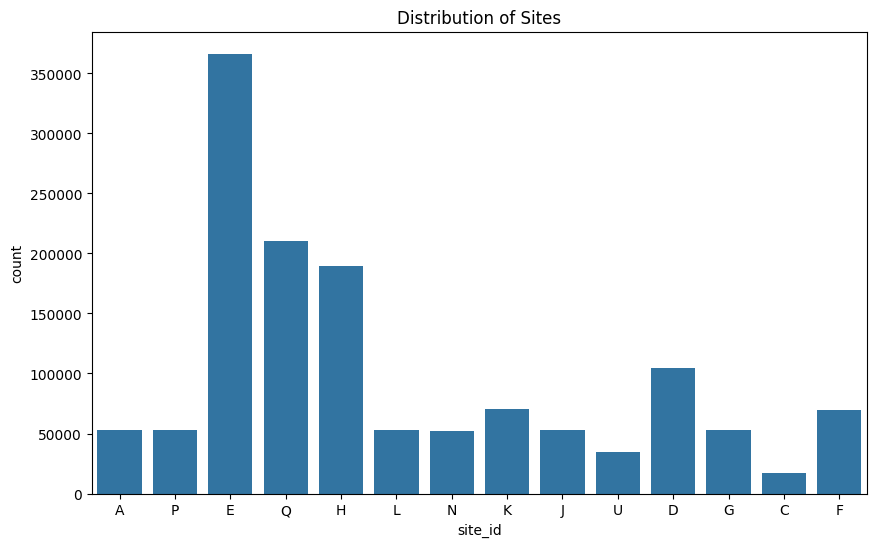

In [ ]:
# Count plot for regions
plt.figure(figsize=(10, 6))
sns.countplot(x='site_id', data=df)
plt.title('Distribution of Sites')
plt.show()


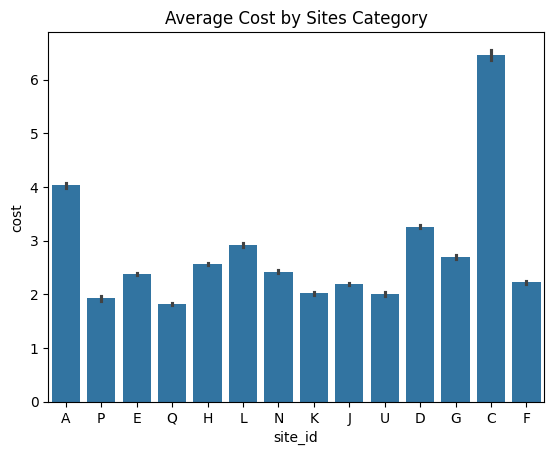

In [ ]:
# Bar plot of average cost by price category
sns.barplot(x='site_id', y='cost', data=df)
plt.title('Average Cost by Sites Category')
plt.show()


In [ ]:
# Categorize time of day
def categorize_time(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df['time_of_day'] = df['hour'].apply(categorize_time)

# Weekend Indicator
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x in [5, 6] else 0)
df

,DateTime,consumption_hh,site_id,region,demand,price,cost,hour,day,weekday,month,time_of_day,is_weekend
0,2013-01-01 00:00:00,0.219,A,A,normal,19.46,2.13087,0,1,1,1,Night,0
1,2013-01-01 00:30:00,0.241,A,A,normal,19.46,2.34493,0,1,1,1,Night,0
2,2013-01-01 01:00:00,0.191,A,A,normal,19.46,1.85843,1,1,1,1,Night,0
3,2013-01-01 01:30:00,0.235,A,A,normal,19.46,2.28655,1,1,1,1,Night,0
4,2013-01-01 02:00:00,0.182,A,A,normal,19.46,1.77086,2,1,1,1,Night,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379305,2013-05-12 20:00:00,0.061,G,C,normal,19.46,0.59353,20,12,6,5,Evening,1
1379306,2013-05-12 20:30:00,0.090,G,C,normal,19.46,0.87570,20,12,6,5,Evening,1
1379307,2013-05-12 21:00:00,0.069,G,C,normal,19.46,0.67137,21,12,6,5,Evening,1
1379308,2013-05-12 21:30:00,0.084,G,C,normal,19.46,0.81732,21,12,6,5,Evening,1


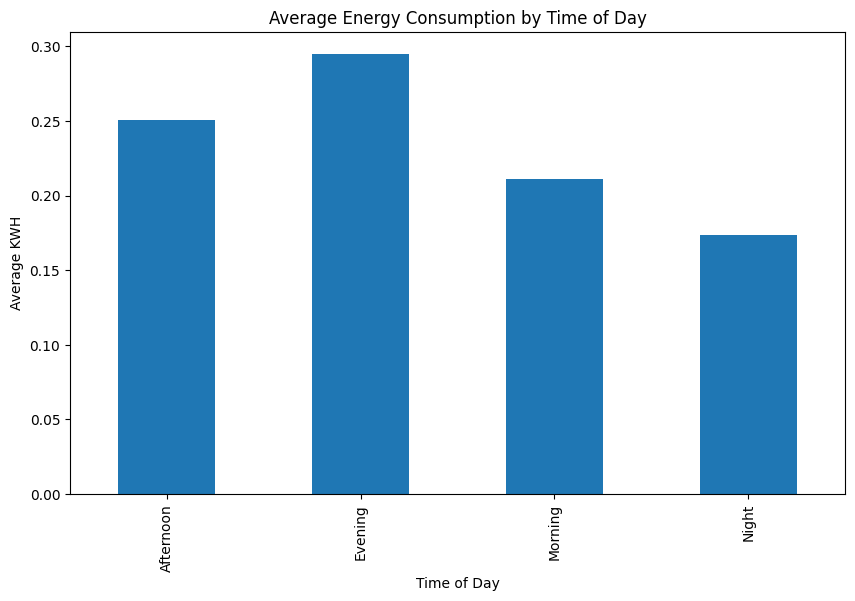

In [ ]:
avg_consumption = df.groupby('time_of_day')['consumption_hh'].mean()
avg_consumption.plot(kind='bar', figsize=(10, 6))
plt.title("Average Energy Consumption by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Average KWH")
plt.show()


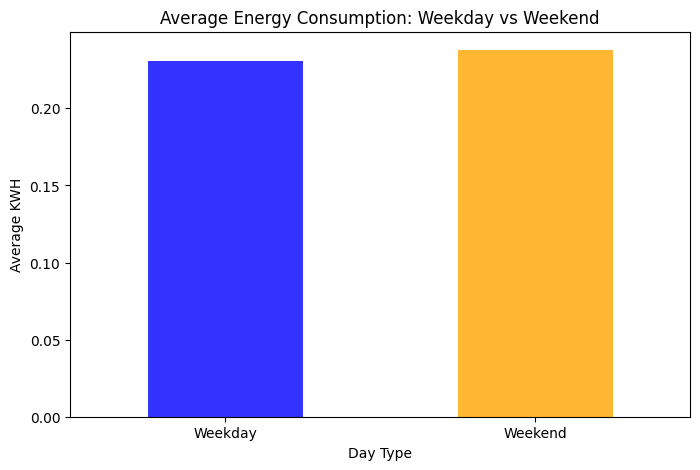

In [ ]:
weekend_data = df.groupby('is_weekend')['consumption_hh'].mean()
weekend_data.index = ['Weekday', 'Weekend']

plt.figure(figsize=(8, 5))
weekend_data.plot(kind='bar', color=['blue', 'orange'], alpha=0.8)
plt.title("Average Energy Consumption: Weekday vs Weekend")
plt.xlabel("Day Type")
plt.ylabel("Average KWH")
plt.xticks(rotation=0)
plt.show()

In [ ]:
region_site_consumption = pd.pivot_table(
    df,
    values='consumption_hh',
    index=['region', 'site_id'],
    aggfunc='sum'
)
region_site_consumption

consumption_hh
region site_id                
A      A          19937.818999
       C          10549.814000
       D          31628.705003
       E          82893.860002
B      K          13374.205998
       L          14243.373000
       N          11750.674999
       P           9988.146004
       Q          36163.211995
C      F          14389.457000
       G          13153.755999
       H          45283.363995
       J          10851.619999
D      U           6528.834000

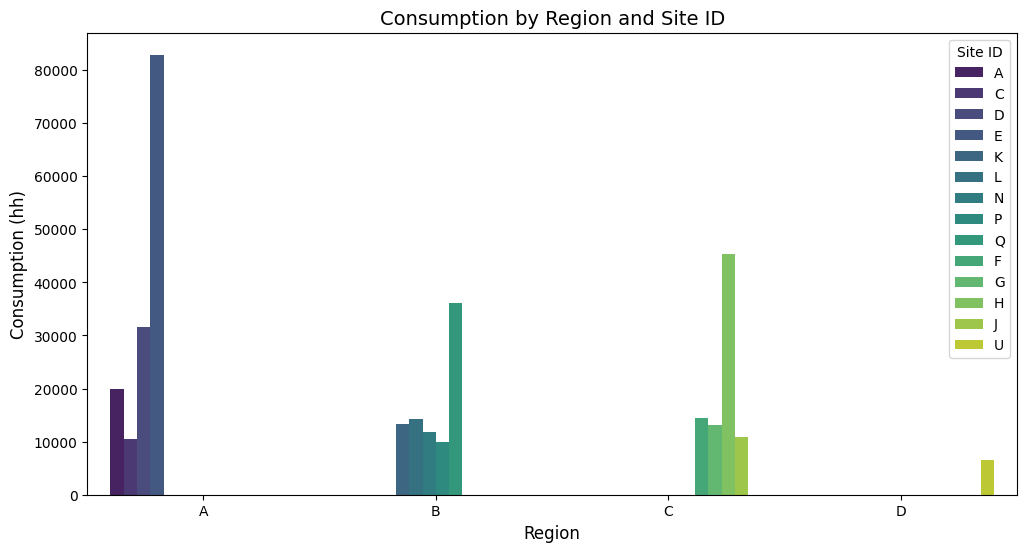

In [ ]:
pivot_table_reset = region_site_consumption.reset_index()

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=pivot_table_reset, x='region', y='consumption_hh', hue='site_id', palette='viridis')

plt.title('Consumption by Region and Site ID', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Consumption (hh)', fontsize=12)
plt.legend(title='Site ID')
plt.show()

### Data Insights


#####  Insights and Potential Implications from Energy Consumption Analysis

**1. Monthly Trends**  
- **Insight**: Months 1 through 4 have higher average energy consumption compared to the rest of 2013.  
- **Implications**:  
  - Increased energy demand in early months may indicate seasonal factors (e.g., winter heating).  
  - Planning energy supply for the first quarter is crucial to avoid shortages or overloading.

**2. Hourly Correlation**
- **Insight**: There is a weak correlation between the hour of the day and energy consumption.  
- **Implications**:  
  - Energy consumption might not strongly time-dependent, which could simplify time-based load predictions.  
  - Further investigation needed

 **3. End-of-Month Consumption**  
- **Insight**: The last day of the month shows relatively higher energy consumption than the rest of the month.  
- **Implications**:    
  - Energy providers might prepare for higher loads toward the month's end to ensure reliability.

**4. Regional Insights**  
- **Insight**:  
  - Region D has significantly fewer sites compared to other regions.  
  - Region D has only one site (Site U), which also has very low energy consumption.  
- **Implications**:  
  - Limited energy infrastructure in Region D could suggest lower population density or industrial activity.  

**5. Site-Specific Insights**  
- **Insight**: Site E in Region A has the highest energy consumption.  
- **Implications**:  
  - High energy usage at Site E might indicate a major industrial or commercial operation.  
  - Monitoring this site closely could help identify opportunities for energy optimization or cost savings.

**6. Weekend vs. Weekday Consumption**  
- **Insight**: Energy consumption is the same on weekends and weekdays.  
- **Implications**:  
  - Consistent consumption patterns suggest a mix of industrial, commercial, and residential activities.  
  - Energy providers may not need separate strategies for weekend vs. weekday supply management.


### Hypothesis Testing

**1- Does the region significantly affect energy consumption?**
- Hypothesis Setup:

 - Null Hypothesis (𝐻0): Region does not significantly affect energy consumption.
 - Alternative Hypothesis (HA): Region does significantly affect energy consumption.

In [ ]:
# ANOVA test because we have multiple categories
pg.pairwise_tests(data = df, dv = 'consumption_hh', between = 'region', padjust = 'sidak')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,region,A,B,False,True,107.765307,946096.830747,two-sided,0.000000e+00,0.000000e+00,sidak,inf,0.210254
1,region,A,C,False,True,56.828387,898725.619902,two-sided,0.000000e+00,0.000000e+00,sidak,inf,0.111395
2,region,A,D,False,True,59.316701,49015.861136,two-sided,0.000000e+00,0.000000e+00,sidak,inf,0.208616
3,region,B,C,False,True,-60.066582,794779.535970,two-sided,0.000000e+00,0.000000e+00,sidak,inf,-0.133627
4,region,B,D,False,True,6.700289,42422.023842,two-sided,2.106018e-11,1.263609e-10,sidak,3.498e+07,0.033714
5,region,C,D,False,True,32.492632,42553.665255,two-sided,8.611522e-229,0.000000e+00,sidak,5.352e+226,0.176863


The *p-unc and p-corr are both < 0.05*  which indicates that
 - **we reject the null hypothesis**

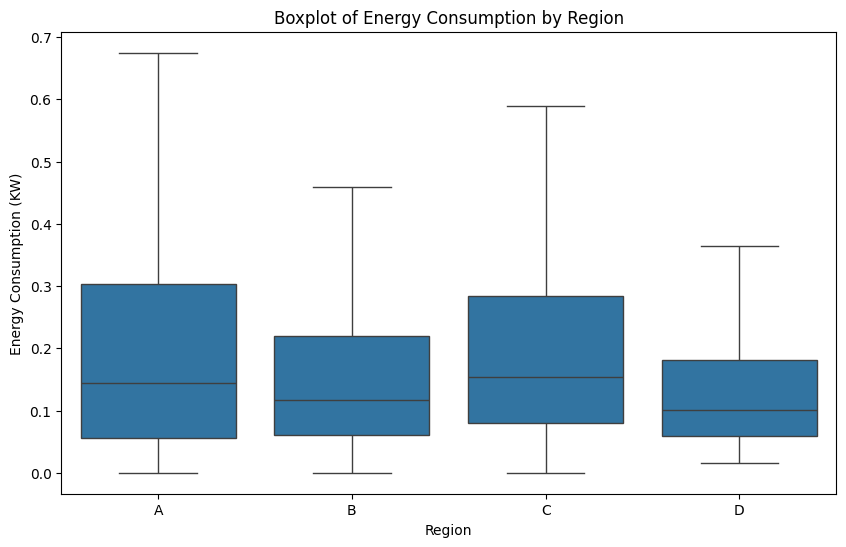

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='consumption_hh', data=df, showfliers=False)
plt.title("Boxplot of Energy Consumption by Region")
plt.xlabel("Region")
plt.ylabel("Energy Consumption (KW)")
plt.show()

**2- Is there a relationship between the time of day and energy consumption?**
- Hypothesis Setup:
 - Null Hypothesis (𝐻0): There is no relationship between time of day and energy consumption.
 - Alternative Hypothesis (𝐻A): There is a relationship between time of day and energy consumption.

In [ ]:
# trying using time od day column first

# Create a contingency table
contingency_table = pd.crosstab(df['consumption_hh'], df['time_of_day'])

# Perform the chi-squared test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Display results
print("Chi-squared Test Results")
print(f"Chi-squared Statistic: {chi2}")
print(f"p-value: {p_value}")
print(f"Degrees of Freedom: {dof}")


if p_value < 0.05:
  print('Reject H0')
else:
  print('Fail to Reject H0')

Chi-squared Test Results
Chi-squared Statistic: 116229.13242687761
p-value: 0.0
Degrees of Freedom: 12276
Reject H0


In [ ]:
#using hour column
pearson_corr, p_pearson = pearsonr(df['hour'], df['consumption_hh'])
spearman_corr, p_spearman = spearmanr(df['hour'], df['consumption_hh'])

print(f"Pearson Correlation: {pearson_corr:.2f} (p-value: {p_pearson:.4f})")
print(f"Spearman Correlation: {spearman_corr:.2f} (p-value: {p_spearman:.4f})")


Pearson Correlation: 0.13 (p-value: 0.0000)
Spearman Correlation: 0.23 (p-value: 0.0000)


In [ ]:
p_value = (p_pearson+p_spearman)/2
if p_value < 0.05:
  print('Reject H0')
else:
  print('Fail to Reject H0')

Reject H0


- whether we used the time of day or hour of the day we will reject the null hypothesis which indicates that **there is a relationship between hour of the day and energy consumption**

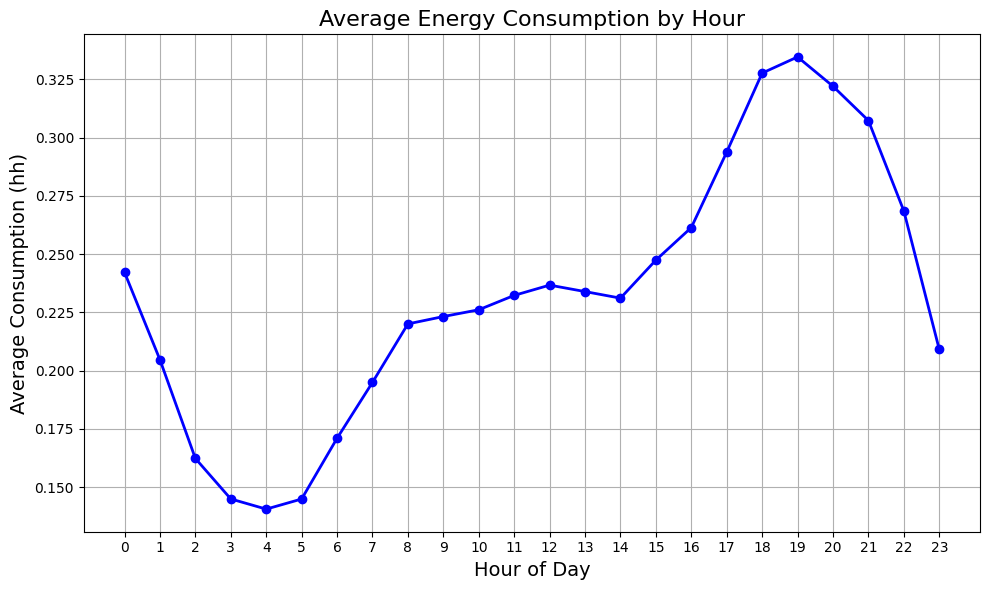

In [ ]:
hourly_avg = df.groupby('hour')['consumption_hh'].mean()

# Plot the line graph
plt.figure(figsize=(10, 6))
hourly_avg.plot(kind='line', marker='o', color='blue', linewidth=2)

plt.title('Average Energy Consumption by Hour', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Average Consumption (hh)', fontsize=14)
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

### Threshold and Cost saving

**3- What is the threshold for low energy consumption to shut down cells, and how much KW and EGP would it save?**


In [ ]:
df.describe().round(2)

,DateTime,consumption_hh,price,cost,hour,day,weekday,month,is_weekend
count,1379297,1379297.00,1379297.00,1379297.00,1379297.00,1379297.00,1379297.00,1379297.00,1379297.00
mean,2013-06-29 15:26:55.789638144,0.23,20.87,2.47,11.50,15.70,2.99,6.43,0.28
min,2013-01-01 00:00:00,0.00,6.89,0.00,0.00,1.00,0.00,1.00,0.00
25%,2013-03-30 12:30:00,0.06,19.46,0.56,5.00,8.00,1.00,3.00,0.00
50%,2013-06-28 12:30:00,0.14,19.46,1.26,11.00,16.00,3.00,6.00,0.00
75%,2013-09-27 15:00:00,0.26,19.46,2.60,18.00,23.00,5.00,9.00,1.00
max,2013-12-31 23:30:00,6.53,77.21,210.94,23.00,31.00,6.00,12.00,1.00
std,NaN,0.32,12.75,4.37,6.92,8.79,2.00,3.44,0.45


In [ ]:
# Checking how much EGP and KWH saved if we used 25th percentile as a threshold
threshold = df['consumption_hh'].quantile(0.25)
below_threshold = df[df['consumption_hh'] < threshold]

# Calculate total energy savings
total_energy_saved = round(below_threshold['consumption_hh'].sum(),2)
print(f"Total Energy Saved: {total_energy_saved} KW")

# Calculate total monetary savings
total_savings_egp = round(below_threshold['cost'].sum(),2)
print(f"Total Monetary Savings: {total_savings_egp} EGP")

Total Energy Saved: 11569.52 KW
Total Monetary Savings: 118193.45 EGP


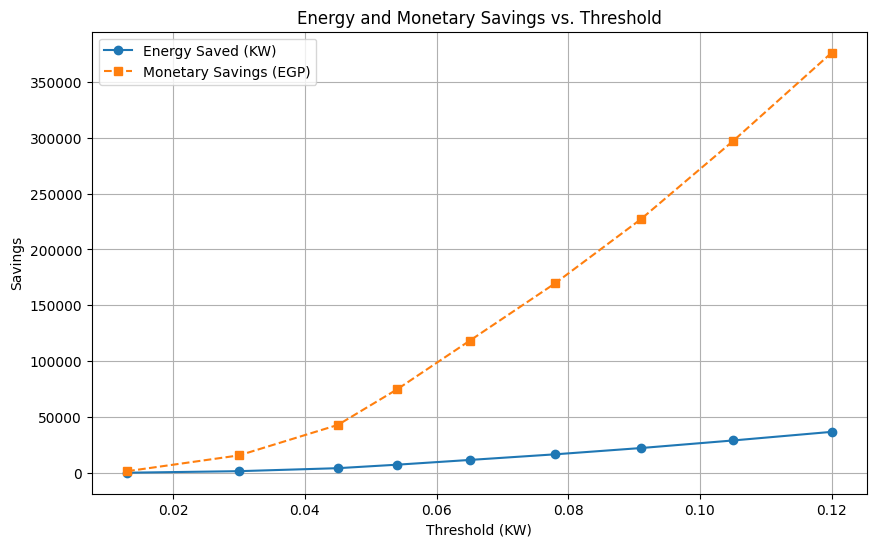

In [ ]:
# exploring if there are better options

# Set thresholds at various percentiles
percentiles = np.arange(0.05, 0.5, 0.05)  # From 5% to 50%
thresholds = df['consumption_hh'].quantile(percentiles)

savings = []
for threshold in thresholds:
    below_threshold = df[df['consumption_hh'] < threshold]
    total_energy_saved = below_threshold['consumption_hh'].sum()
    total_savings_egp = below_threshold['cost'].sum()
    savings.append((threshold, total_energy_saved, total_savings_egp))

# Convert savings to a DataFrame for easy plotting
savings_df = pd.DataFrame(savings, columns=['Threshold', 'Energy_Saved_KW', 'Savings_EGP'])

plt.figure(figsize=(10, 6))
plt.plot(savings_df['Threshold'], savings_df['Energy_Saved_KW'], label="Energy Saved (KW)", marker='o')
plt.plot(savings_df['Threshold'], savings_df['Savings_EGP'], label="Monetary Savings (EGP)", marker='s', linestyle='--')
plt.title("Energy and Monetary Savings vs. Threshold")
plt.xlabel("Threshold (KW)")
plt.ylabel("Savings")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Threshold candidates
threshold_candidates = [0.04,0.05, 0.06]

# Analyze the impact at each threshold
for threshold in threshold_candidates:
    below_threshold = df[df['consumption_hh'] < threshold]
    energy_saved = below_threshold['consumption_hh'].sum()
    monetary_saved = below_threshold['cost'].sum()
    num_cells = below_threshold.shape[0]

    print(f"Threshold: {threshold:.2f} KW")
    print(f"  - Energy Saved: {energy_saved:.2f} KW")
    print(f"  - Monetary Savings: {monetary_saved:.2f} EGP")
    print(f"  - Number of Cells Shut Down: {num_cells}")
    print("----")


Threshold: 0.04 KW
  - Energy Saved: 3174.12 KW
  - Monetary Savings: 32316.05 EGP
  - Number of Cells Shut Down: 181027
----
Threshold: 0.05 KW
  - Energy Saved: 5805.55 KW
  - Monetary Savings: 59170.50 EGP
  - Number of Cells Shut Down: 239541
----
Threshold: 0.06 KW
  - Energy Saved: 9829.94 KW
  - Monetary Savings: 100310.92 EGP
  - Number of Cells Shut Down: 313563
----


**0.06 (25th percentile) is the threshold that has the highest monetary savings it is also at the elbow of the graph**